In [1]:
#STEP 1
import numpy as np
import random
import tensorflow as tf
import math
from collections import Counter
from itertools import combinations
from copy import deepcopy

/Users/amieramie/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/amieramie/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/amieramie/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/amieramie/opt/anaconda3/lib/python3.7/site-packages

In [2]:
#STEP 2
#allows us to see how many actions sets would exist for a n = board_size^2 and a r = # of shots/turn 
def nCr(n,r):
    f = math.factorial
    return f(n) / f(r) / f(n-r)

In [3]:
#finding the longest consecutive sequence of the element within a list
def longest_seq(seq):
    maxrun = -1
    rl = {}
    lists_of_runs = []
    for x in seq:
        run = rl[x] = rl.get(x-1, 0) + 1
        if run > maxrun:
            maxend, maxrun = x, run
    return maxrun 

In [4]:
#code appropriated for the random game board creation use case from here: https://stackoverflow.com/questions/7352684/how-to-find-the-groups-of-consecutive-elements-in-a-numpy-array
#input a list and the minimum size of the group needed and get the starting coordinates of all groups
#larger than the given size
#the groups in [0,0,0,2,2,1,1,1] for example would be [0,0,0] starting at index 0, [2,2] starting at index 3,
#and [1,1,1] starting at index 5
def group_consecutives(vals, size,step=1):
    """Return list of consecutive lists of numbers from vals (number list)."""
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    return [element for element in result if len(element) >= size ]

In [5]:
def create_random_board(SHIP_SIZES, board_size):
    #creating a random board of board_size x board_size filled initally with -1's
    board = np.zeros((board_size,board_size),dtype=(int))
    board[:] = -1
    
    #iterating through placing each ship size
    for ship_size in SHIP_SIZES:
        #finding the remaining coordinates where we can place a ship
        possible_ship_coords = np.array(np.where(board == -1)).transpose()
        #if statement is to be able to randomly place the ship horizontally or vertically
        if random.uniform(0, 1)>.5:
            #horizontal
            #finding all possible rows that have enough space for the current ship size
            possible_rows = np.unique(possible_ship_coords[:,0])
            possible_rows = possible_rows[np.where(np.array([longest_seq(possible_ship_coords[possible_ship_coords[:,0]==row][:,1]) for row in possible_rows])>=ship_size)[0]]
            
            #if there are ways to place the current ship size into any of the rows then randomly place it
            #in one of those places
            
            #if not find out if there are ways to place the current ship size along the columns
            if len(possible_rows)>0:
                #choose a random row out of the possible rows
                row = random.choice(possible_rows)
                #get the starting column coordinate of all starting coordinates that have enough spaces to the right
                #to fit the ship - this is found using the group_consecutives list
                spaces = group_consecutives(possible_ship_coords[possible_ship_coords[:,0] == row][:,1],ship_size)
                #choose a random starting column coordinate from the list of column coordinates that can fit
                #the current sized ship
                space = random.choice(spaces)
                #the consecutive group size may be larger than the ship size so the first index
                #of the group may not be the only viable starting coordinate for the ship
                #because of this we find the other viable coordinates within the group that are also viable
                #the starting column index will be that index
                column = space[random.choice(list(range(len(space)-ship_size+1)))]
                #setting everything to the right of that starting element equal to the ship size (representing the ship location)
                board[row,column:column+ship_size] = ship_size
                #print('Created ship horizontally')
            else:
                #if there are no more ways to place a ship horizontally then try vertically
                #go through the same exact process as above except trying to place a ship along a single column
                #across several rows
                possible_columns = np.unique(possible_ship_coords[:,0])
                possible_columns = possible_columns[np.where(np.array([longest_seq(possible_ship_coords[possible_ship_coords[:,1]==column][:,0]) for column in possible_columns])>=ship_size)[0]]
                if len(possible_columns)>0:
                    column = random.choice(possible_columns)
                    spaces = group_consecutives(possible_ship_coords[possible_ship_coords[:,1] == column][:,0],ship_size)
                    space = random.choice(spaces)
                    row = space[random.choice(list(range(len(space)-ship_size+1)))]
                    board[row:row+ship_size,column] = ship_size
                    #print('Created ship vertically')
                else:
                    #if this fails there are no ways to place the current ship size in the current board
                    #configuration so skip the ship
                    #this would likely only happen if we have a lot of large ships in a comparitively small board
                    print('No more spaces to place ship, going on to the next ship')
        else:
            #go through the same exact process if we intially chose to place the current sized ship along a single column instead
            possible_columns = np.unique(possible_ship_coords[:,0])
            possible_columns = possible_columns[np.where(np.array([longest_seq(possible_ship_coords[possible_ship_coords[:,1]==column][:,0]) for column in possible_columns])>=ship_size)[0]]
            if len(possible_columns)>0:
                column = random.choice(possible_columns)
                spaces = group_consecutives(possible_ship_coords[possible_ship_coords[:,1] == column][:,0],ship_size)
                space = random.choice(spaces)
                row = space[random.choice(list(range(len(space)-ship_size+1)))]
                board[row:row+ship_size,column] = ship_size
                #print('Created ship vertically')
            else:
                possible_rows = np.unique(possible_ship_coords[:,0])
                possible_rows = possible_rows[np.where(np.array([longest_seq(possible_ship_coords[possible_ship_coords[:,0]==row][:,1]) for row in possible_rows])>=ship_size)[0]]
                if len(possible_rows)>0:
                    row = random.choice(possible_rows)
                    spaces = group_consecutives(possible_ship_coords[possible_ship_coords[:,0] == row][:,1],ship_size)
                    space = random.choice(spaces)
                    column = space[random.choice(list(range(len(space)-ship_size+1)))]
                    board[row,column:column+ship_size] = ship_size 
                    #print('Created ship horizontally')
                else:
                    print('No more spaces to place ship, going on to the next ship')
    return board

In [6]:
SHIP_SIZES = [3,2,2]
board_size = 5
board = create_random_board(SHIP_SIZES, board_size)

In [7]:
board

array([[-1, -1, -1, -1, -1],
       [-1, -1, -1,  3, -1],
       [ 2, -1, -1,  3,  2],
       [ 2, -1, -1,  3,  2],
       [-1, -1, -1, -1, -1]])

In [8]:
#changing board based on this methodology: hits -> 1, 0 -> misses, -1 -> unknown/not shot at yet
#takes in a board, a list of coordinates to shoot at, and the number of moves per turn
def play_move(g_board, moves_arr, num_moves_in_turn):
    #setting a new copy of a gameboard
    game_board = g_board + 1 - 1
    #arbitrary metric to see how many hits/misses we have in the current state
    previous_state = sum((game_board == 1).flatten())/sum((game_board == 0).flatten())
    #in case the moves_arr has more moves than the number of shots/turn
    moves = moves_arr[0:num_moves_in_turn]
    hits = 0
    misses = 0
    repeat = 0
    count = 1
    #for each shot in the moves array make the correct change on the game board and count hits and misses
    for move in moves:
        if game_board[move[0]][move[1]] == -1:
            game_board[move[0]][move[1]] = 0
            misses +=1
        elif game_board[move[0]][move[1]] > 1:
            game_board[move[0]][move[1]] = 1
            hits+=1
        else:
            repeat+=1
        count+=1
        
    #find the spots that haven't been shot at yet
    available_spots = ((game_board == -1)|(game_board > 1)).flatten()
    available_moves = np.where(available_spots==True)[0]
    return (game_board,previous_state,hits,repeat, available_moves,sum((game_board == 1).flatten()))#new game board, number of hits and misses previous turns, number of hits and misses this turn, possible moves next turn, total number of hits

In [9]:
#Used for creating the all_coords array - an array with all the possible coords in a board found by 
#iterating row by row 
#getting all possible coordinates within a board found by iterating across each row
def possible_moves(board_size):
    return np.array([[row,column] for row in range(board_size) for column in range(board_size)])

In [10]:
#Used for creating possible_combinations array - an array with a aseries of actions sets 
#where each action set contains a series of indexes referencing a coordinate in the all_coords array
#the possible_combinations array represents all possible action sets and its indexes will align with output 
#probability array from the NN
#getting all possible actions sets given the size of the board and the number of moves per turn
def possible_move_sets(board_size, number_moves_in_turn):
    comb = combinations(list(range(0,board_size*board_size)), number_moves_in_turn)
    return list(comb)

In [11]:
TRAINING = True
RANDOM = False
def play_game(training=TRAINING,random = RANDOM):
    """ Play game of battleship using network."""
    #initializing array such that we can keep track of coords that we cannot revisit after already shooting at them
    impossible_coords = np.array([])
    #creating random board
    board = create_random_board(SHIP_SIZES, board_size)
    #creating the NN version of board that can be passed into the NN: 1 = hits, 0 = misses, -1 = unknown
    nn_board = deepcopy(board)
    nn_board[nn_board>1] = -1
    # Initialize logs for game
    # initializing logs for keeping track of boards, nn_boards, actions sets taken, and hits after each action
    board_position_log = [board]
    board_position_log_nn = [nn_board]
    action_log = []
    hit_log = []
    # allows us to toggle between random player and trained AI
    if not random:
        #TRAINED AI
        #until we have hit all the ships keep playing moves
        while sum(hit_log) < sum(SHIP_SIZES):
            #given the current NN run the nn_board through the architecture and get the probability distribution acrioss all possible action sets
            probs = sess.run([probabilities], feed_dict={input_positions:nn_board.flatten().reshape(-1,board_size*board_size)})[0][0]
            #0 out all probabilities for actions sets that are not possible i.e. one or more of their coordinates has been shot at already
            probs = [p * (index not in impossible_coords) for index, p in enumerate(probs)]
            #renormalize the resulting probability distribtuion so everything adds up to 1
            probs = [p / sum(probs) for p in probs]
            #this is a toggle to be able to train stochastically, such that we have some chance of exploration
            if training == True:
                #This if statement allows us to deal with cases where there are fewer coordinates left 
                #to be shot at than the number of actions in an action set (number of shots per turn).
                #In this case, since there will be no possible action set that is viable (all of them would have been 0'd out
                #since at least one coordinate in every set would have been shot at), the last turn will be simply shooting at
                #the remaining available coordinates. Look at the else statement for what is done in that case
                if number_moves_per_turn <= sum(((board == -1)|(board >1)).flatten()):
                    #if there are still action sets that are viable pick a random action set from the list of
                    #all actions sets stochastically based on the NN ouput probs
                    index = np.random.choice(list(range(0,len(possible_combinations))), p=probs)
                    bomb_index = possible_combinations[index]
                else:
                    #if there are fewer available coords left then actions in an action set (# shots/turn)
                    #then find the remaining coordinates and shoot them out, since there will be no action
                    #set available to do so
                    remaining_coords = np.where(((board).flatten()==-1)|((board).flatten()>1))[0]
                    moves = all_coords[remaining_coords]
                    #play out shooting at those coordinates
                    move_out = play_move(board, moves, sum(((board == -1)|(board >1)).flatten()))
                    #get the resulting board
                    board = move_out[0]
                    #create the NN version of that board
                    nn_board = deepcopy(board)
                    nn_board[nn_board>1] = -1
                    #get the number of hits from the shot(s) and append it to the log
                    hit_log.append(move_out[2])
                    #append the action index to the action log and the board states into their respective logs as well
                    for coordinate_index in remaining_coords:
                        action_log.append(coordinate_index)
                    board_position_log.append(board)
                    board_position_log_nn.append(nn_board)
                    #break from the loop since this case would only happen if we've filled up the entire
                    #board except a couple of spots
                    break
            else:
                #if we're not training go through the same process, but instead of stochastically choosing
                #the next action set, deterministically choose the next actions set based on the NN probs
                
                #this if statement is again to deal with the case where there are fewer available coords 
                #left then actions in an action set (# shots/turn)
                if number_moves_per_turn <= sum(((board == -1)|(board >1)).flatten()):
                    index = np.argmax(probs)
                    bomb_index = possible_combinations[index]

                else:
                    #same methodology as whats in the training process
                    remaining_coords = np.where(((board).flatten()==-1)|((board).flatten()>1))[0]
                    moves = all_coords[remaining_coords]
                    move_out = play_move(board, moves, sum(((board == -1)|(board >1)).flatten()))
                    board = move_out[0]
                    nn_board = deepcopy(board)
                    nn_board[nn_board>1] = -1    
                    hit_log.append(move_out[2])
                    for coordinate_index in remaining_coords:
                        action_log.append(coordinate_index)
                    board_position_log.append(board)
                    board_position_log_nn.append(nn_board)
                    break
            #an action set where the number of shots/turn is 2 for example would look like this:
            #(2,4). If we assume a 4x4 board 2 would correspond to [0,2] and 4 would correspond to [1,0].
            #this is because the data structure: all_coords, is a list of all possible coordinates for a board
            #created by iterating through each row
            #therefore this is pulling out the corresponding coordinates from the action set and putting them
            #into a list that will then be used in the play_move function
            moves = [all_coords[shot] for shot in bomb_index]
            #play move based on all board, shots, and the number of moves per turn
            move_out = play_move(board, moves, number_moves_per_turn)
            #saving the new resulting board
            board = move_out[0]
            #creating the NN board representation from that new board
            nn_board = deepcopy(board)
            nn_board[nn_board>1] = -1   
            # update logs  
            hit_log.append(move_out[2])
            action_log.append(index)
            board_position_log.append(board)
            board_position_log_nn.append(nn_board)
            
            #here we are trying to recalculate all the action sets that should no longer be considered
            #the way we do that is checking if any dimension within the action set has a coordinate that was just shot at.
            #If any action set has a coordinate that has already been shot at append its index from the action set list to the
            #impossible_coords list so we can 0 it out in the NN output probs 
            for coord_index in bomb_index :
                for column in range (number_moves_per_turn):
                    impossible_coords = np.concatenate((impossible_coords,np.where(possible_combinations[:,column]==coord_index)[0]),axis = 0)
    else:
        #RANDOM PLAYER
        #until we have hit all the ships keep playing moves
        while sum(hit_log) < sum(SHIP_SIZES):
            #creating a uniform probability distribution across all the possible action sets
            probs = [1/len(possible_combinations)]*len(possible_combinations)
            #0'ing out all probabilities associated with actions sets that have a coordinate that has already
            #been shot at
            probs = [p * (index not in impossible_coords) for index, p in enumerate(probs)]
            #this if statement is again to deal with the case where there are fewer available coords 
            #left then actions in an action set (# shots/turn)
            if number_moves_per_turn <= sum(((board == -1)|(board >1)).flatten()):
                #if we still have action set available, since we have more coordinates left to be shot than
                #actions in the action set (number of shots/turn) #then renormalize the probabilities such
                #that the add to 1
                probs = [p / sum(probs) for p in probs] 
                #select a random action set index and action set based on those even probabilities
                index = np.random.choice(list(range(0,len(possible_combinations))), p=probs)
                bomb_index = possible_combinations[index]
            else:
                #if we do not have an action set available find the remaining coords that need to be shot at
                bomb_index = np.where(((board).flatten()==-1)|((board).flatten()>1))[0]
            #again pulling all the coordinates 
            moves = [all_coords[shot] for shot in bomb_index]
            #playing move
            move_out = play_move(board, moves, number_moves_per_turn)
            #saving the new resulting board
            board = move_out[0]
            #creating the NN board representation from that new board
            nn_board = deepcopy(board)
            nn_board[nn_board>1] = -1   
            # update logs  
            hit_log.append(move_out[2])
            action_log.append(index)
            board_position_log.append(board)
            board_position_log_nn.append(nn_board)
            
            #same as above -> adding the coords we should not re shoot at into the impossible_coords list
            for coord_index in bomb_index :
                for column in range (number_moves_per_turn):
                    impossible_coords = np.concatenate((impossible_coords,np.where(possible_combinations[:,column]==coord_index)[0]),axis = 0)    
    return board_position_log_nn,board_position_log, action_log, hit_log#, repeat, np.array(actual_actions), impossible_coords,list_of_probs

In [12]:
#pulled from https://www.efavdb.com/battleship
#explaination is in paper
def rewards_calculator(hit_log, gamma=0.5):
    #the if statement was added to potentially tune a higher rewards value for having multiple hits within a turn
    """ Discounted sum of future hits over trajectory"""
    hit_log_weighted = [(item - float( sum(SHIP_SIZES) - sum(hit_log[:index])) / float(board_size**2 - index))* (gamma ** index)
    if item>1 else (item -float( sum(SHIP_SIZES) - sum(hit_log[:index])) / float(board_size**2 - index)) 
    * (gamma ** index) for index, item in enumerate(hit_log)]
    return [((gamma) ** (-i)) * sum(hit_log_weighted[i:]) for i in range(len(hit_log))]

In [13]:
#STEP 3
#setting board conditions
SHIP_SIZES = [4,2]
board_size = 4
number_moves_per_turn = 1

In [14]:
#STEP 4
#pulled from https://www.efavdb.com/battleship
#using the same exact NN architecture as the one in the article
input_units = board_size*board_size
hidden_units = board_size*board_size
output_units = int(nCr(hidden_units,number_moves_per_turn))

input_positions = tf.placeholder(tf.float32, shape=(1, input_units))
labels = tf.placeholder(tf.int64)
learning_rate = tf.placeholder(tf.float32, shape=[])
# Generate hidden layer
W1 = tf.Variable(tf.truncated_normal([input_units, hidden_units], stddev=0.1 / np.sqrt(float(input_units))))

b1 = tf.Variable(tf.zeros([1, hidden_units]))
h1 = tf.tanh(tf.matmul(input_positions, W1) + b1)
# Second layer -- linear classifier for action logits
W2 = tf.Variable(tf.truncated_normal([hidden_units, output_units], stddev=0.1 / np.sqrt(float(hidden_units))))
b2 = tf.Variable(tf.zeros([1, output_units]))
logits = tf.matmul(h1, W2) + b2
probabilities = tf.nn.softmax(logits)

init = tf.initialize_all_variables()
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = labels, name='xentropy')
train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cross_entropy)
# Start TF session
sess = tf.Session()
sess.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [15]:
#STEP 5
#creating the all_coords array - an array with all the possible coords in a board found by iterating row by row
#also creating possible_combinations array - an array with a aseries of actions sets where each action set contains
#a series of indexes referencing a coordinate in the all_coords array
#the possible_combinations array represents all possible action sets and its indexes will align with output probability array
#from the NN
TRAINING = True
RANDOM = False
all_coords = possible_moves(board_size)
possible_combinations = np.array(possible_move_sets(board_size, number_moves_per_turn))

In [16]:
#testing game play mechanic
board_position_log_nn,board_position_log, action_log, hit_log = play_game(training=True,random = False)

/Users/amieramie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


In [17]:
#pulled from https://www.efavdb.com/battleship
#iterating through simulating games and using the resulting hits log(and the calculated rewards from the hits log)
#to backpropogate and update the weights
game_lengths = []
TRAINING = True # Boolean specifies training mode
ALPHA = 0.06 # step size
rewards = []
for game in range(10000):
    board_position_log_nn, board_position_log, action_log, hit_log  = play_game(training=TRAINING,random = False)
    game_lengths.append(len(action_log))
    rewards_log = rewards_calculator(hit_log)
    rewards.append(sum(rewards_log))
    for reward, current_board, action in zip(rewards_log, board_position_log_nn, action_log):
        # Take step along gradient
        if TRAINING:
            sess.run([train_step],
                feed_dict={input_positions:current_board.flatten().reshape(-1,board_size*board_size), labels:[action], learning_rate:ALPHA * reward})
    if game%500 == 0:
        print(game)

/Users/amieramie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys
/Users/amieramie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in long_scalars
  import sys


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


In [18]:
#STEP 6
#getting the average number of moves the AI needed to solve a set of 500 games - using deterministic gameplay
#where we always pick the action set with the highest probability (unlike the stochastic training)
num_actions = []
for i in range(0,500):
    board_position_log_nn,board_position_log, action_log, hit_log = play_game(training=False, random = False)
    num_actions.append(len(action_log))
np.array(num_actions).mean()

/Users/amieramie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys
/Users/amieramie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in long_scalars
  import sys


11.756

In [19]:
#getting the average number of moves the random player needed to solve a set of 500 games
num_actions = []
for i in range(0,500):
    board_position_log_nn,board_position_log, action_log, hit_log = play_game(training=False,random=True)
    num_actions.append(len(action_log))
np.array(num_actions).mean()

/Users/amieramie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys
/Users/amieramie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in long_scalars
  import sys


14.696

In [ ]:
#STEP 7
#A SERIES OF GRAPHS FOR EACH BOARD CASE
#Each data point in the graph represents the average number of moves taken to solve boards for sets of 100 games simulated 
#The data points are taken across 10000 iterations of training to see if the average number of moves needed
#for a given board case goes down with more training (i.e. is the AI actually learning)

In [20]:
import matplotlib.pyplot as plt

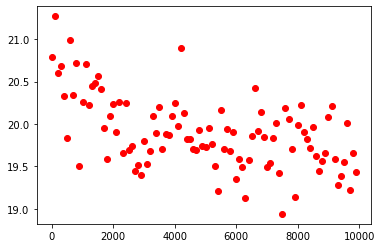

In [357]:
#board size 5; ship sizes 3,2,2; number of moves per turn 1 -> 13s /500
# step = 100
# average_num_moves =[]
# for i in range(0,10000,step):
#     average_num_moves.append(np.array(game_lengths[i:i+step]).mean())
# plt.plot(range(0,10000,step),average_num_moves,'ro')

/Users/amieramie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """


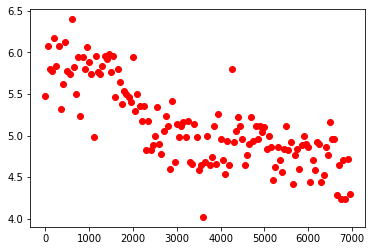

In [312]:
#board size 4; ship sizes 2; number of moves per turn 2 -> 13s /500
# step = 100
# average_num_moves =[]
# for i in range(0,10000,step):
#     average_num_moves.append(np.array(game_lengths[i:i+step]).mean())
# plt.plot(range(0,10000,step),average_num_moves,'ro')

/Users/amieramie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """


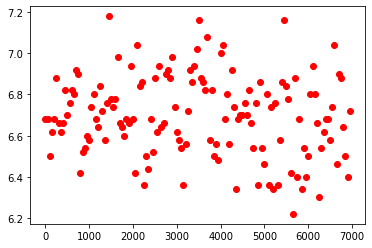

In [305]:
#board size 4; ship sizes 2,2; number of moves per turn 2 -> 13s /500
# step = 100
# average_num_moves =[]
# for i in range(0,10000,step):
#     average_num_moves.append(np.array(game_lengths[i:i+step]).mean())
# plt.plot(range(0,10000,step),average_num_moves,'ro')

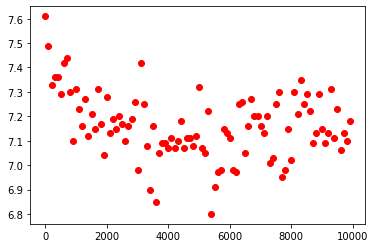

In [388]:
#board size 4; ship sizes 4,2; number of moves per turn 2 -> 14s /500
# step = 100
# average_num_moves =[]
# for i in range(0,10000,step):
#     average_num_moves.append(np.array(game_lengths[i:i+step]).mean())
# plt.plot(range(0,10000,step),average_num_moves,'ro')

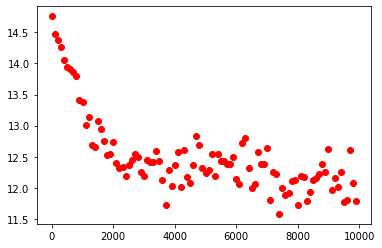

In [21]:
# #board size 4; ship sizes 4,2; number of moves per turn 1 -> 14s /500
# step = 100
# average_num_moves =[]
# for i in range(0,10000,step):
#     average_num_moves.append(np.array(game_lengths[i:i+step]).mean())
# plt.plot(range(0,10000,step),average_num_moves,'ro')

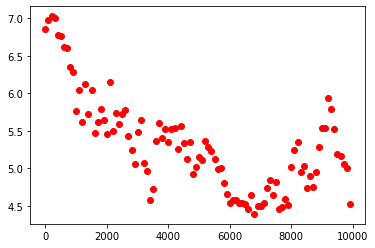

In [237]:
#board size 4; ship sizes 4; number of moves per turn 2 -> 11s /500
# step = 100
# average_num_moves =[]
# for i in range(0,10000,step):
#     average_num_moves.append(np.array(game_lengths[i:i+step]).mean())
# plt.plot(range(0,10000,step),average_num_moves,'ro')

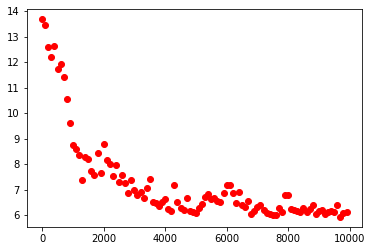

In [224]:
#board size 4; ship sizes 4; number of moves per turn 1 -> 3s /500
# step = 100
# average_num_moves =[]
# for i in range(0,10000,step):
#     average_num_moves.append(np.array(game_lengths[i:i+step]).mean())
# plt.plot(range(0,10000,step),average_num_moves,'ro')

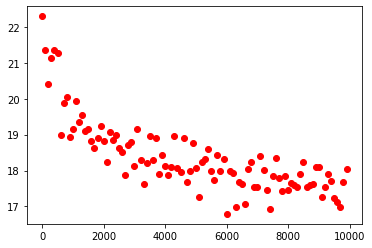

In [218]:
# #board size 5; ship sizes 4,2; number of moves per turn 1 -> 10s/500
# step = 100
# average_num_moves =[]
# for i in range(0,10000,step):
#     average_num_moves.append(np.array(game_lengths[i:i+step]).mean())
# plt.plot(range(0,10000,step),average_num_moves,'ro')